# P10-Détectez des faux billets avec R ou Python


In [84]:
# Ici j'importe mes librairies afin de traiter toutes mes données 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import scipy as sc
import seaborn as sns; sns.set()
from sklearn import decomposition 
from sklearn import preprocessing 
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.preprocessing import StandardScaler
import  scipy.signal.signaltools
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# Librairies de calcul:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

# Libairies de representation graphique:
import matplotlib.pyplot as plt
import seaborn as sns

# Pour la regression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad

# Pour la regression logistique:
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score


def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

# 1- Traitement des données

In [2]:
# df des valeurs observées
billets=pd.read_csv('money.csv', delimiter=';')
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [3]:
billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


In [4]:
billets.shape

(1500, 7)

In [5]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [6]:
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Ci-dessus on peut voir qu'il y a 37  valeurs manquantes à la colonne "margin_low" 

In [7]:
# df avec les valeurs manquantes

margin_low_null=billets[billets['margin_low'].isnull()]
margin_low_null

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [8]:
# On supprime les  37 lignes pour lesquelles ml est nul de notre fichier 
# df sans les valeurs nulles
money_not_null=billets[billets['margin_low'].notnull()]
money_not_null.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [9]:
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

<Figure size 1440x1440 with 0 Axes>

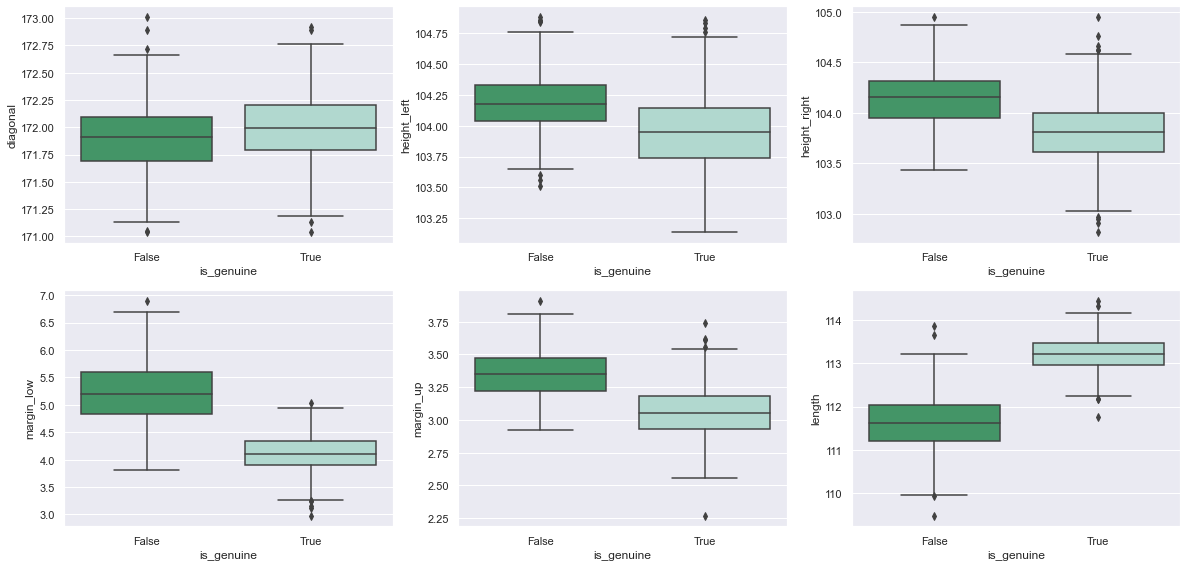

In [10]:
#Caractérisation des groupes en fonction des variables
plt.figure(figsize=(20,20))
f, ax = plt.subplots(figsize=(20, 20))
plt.subplot(431)
sns.boxplot(x="is_genuine", y="diagonal", data=billets, palette='BuGn_r')
plt.subplot(432)
sns.boxplot(x="is_genuine", y="height_left", data=billets, palette='BuGn_r')
plt.subplot(433)
sns.boxplot(x="is_genuine", y="height_right", data=billets, palette='BuGn_r')
plt.subplot(434)
sns.boxplot(x="is_genuine", y="margin_low", data=billets, palette='BuGn_r')
plt.subplot(435)
sns.boxplot(x="is_genuine", y="margin_up", data=billets, palette='BuGn_r')
plt.subplot(436)
sns.boxplot(x="is_genuine", y="length", data=billets, palette='BuGn_r')

plt.savefig('boxplot_production.png')

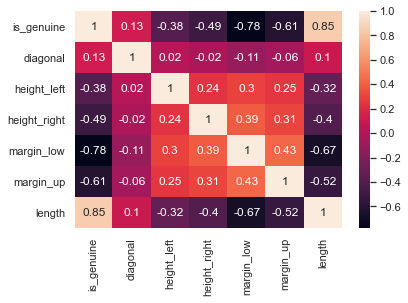

In [11]:
correlation_matrix = billets.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.savefig('heatmap_correlation.png')

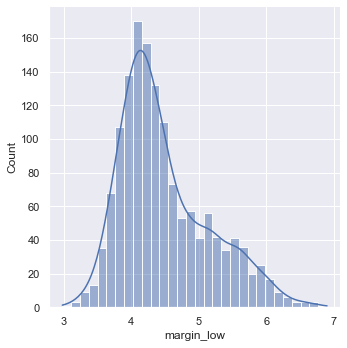

In [12]:
sns.displot(data=billets, x='margin_low', bins=30,kde=True);
plt.savefig('histogramme.png')

In [13]:
margin_low_null

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


# 2- Régression linéaire pour estimer les valeurs manquantes

In [76]:
# Separation des donnees manquantes des donnees manquantes:
Reg_Lin_Train_df = billets.dropna()
Reg_Lin_Test_df = billets[billets.isnull().any(axis=1)]

# Creation de X_train et Y_train:
x_train = Reg_Lin_Train_df.drop("margin_low", axis=1)
y_train = Reg_Lin_Train_df["margin_low"]

# Regression lineaire:
reg_lin = LinearRegression()
model_reg_lin = reg_lin.fit(x_train, y_train)

# Predictions:
x_train = Reg_Lin_Train_df[["is_genuine","diagonal","height_left","height_right", "margin_up", "length"]]
Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)

<ipython-input-76-6174f86785ba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)


In [77]:
print("Intercept:", model_reg_lin.intercept_)
print("Coéfficients:", model_reg_lin.coef_)

Intercept: 2.8668228920542846
Coéfficients: [-1.14059676 -0.0130159   0.02829069  0.02674982 -0.21284432 -0.00388299]


In [79]:
# Instanciation:
reg_linb = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length", data = billets)

# Calculs:
res_lin = reg_linb.fit()
print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          2.60e-202
Time:                        12:50:01   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Test d'hypothèses par analyse des résidus:


Il y a plusieurs hypothèses à tester pour la régression linéaire :

Normalité de la distribution des résidus : Omnibus test, l'hypothèse nulle est que les résidus sont distribués selon une loi Normale. La valeur de Prob(Omnibus) doit être proche de 1. Ici elle est nulle ce qui implique que l'hypothèse n'est pas verifée, les coefficiants estimés ne seront pas BLUE. Prob(Jacque-Bera) est redondant avec Prob(Omnibus), une valeur élevée pour le Jarque-Bera indique que les résidus sont distribués selon une loi Normale. Pour lever le doute on effectue un test d'Aderson-Darling qui nous indique que les résidus suivent une distribution Normale.

Homocédasticité : les variances des résidus doivent être constantes. Les tests de Breusch-Pagan et de White permettent de tester l'hypothèse d'homoscédasticité du terme d'erreur d'un modèle de régression linéaire. Le test de Breusch-Pagan ne fonctionne pas très bien pour les distributions non-normales et non-linéaires contrairement au test de White qui est en fait un cas particulier du Breusch-Pagan. Il existe aussi le test de Goldfeld et Quandt qui n'est plus vraiment utilisé.

Non-autocorrélation : l'autocorrélation est la corrélation des erreurs (résidus) dans le temps. Durbin-Watson < 1.5, autocorrélation positive, l'hypothèse n'est pas satisfaite. 1.5 < Durbin-Watson < 2.5 pas d'autocorrélation, l'hypothèse est satisfaite. Durbin-Watson > 2.5, autocorrélation négative, l'hypothèse n'est pas satisfaite. Ici, il est de 1.888, il n'y a donc pas d'autocorrélation.
Multicollinéarité : on suppose que les prédicteurs utilisés dans la régression ne sont pas corrélés les uns aux autres. Le cond. No. est élevée il semble qu'il y ai un problème de multicollinéarité. Le VIF indique effectivment une forte multicolinéarité.

Linéarité : on fait l'hypothèse qu'il existe une relation linéaire entre les variables indépendantes et la variable dépendante. Non verifée ici, les estimateurs ne seront pas BLUE (ils sont biaisés).
Si l'hypothèse de non-colinéarité n'est pas vérifiée, l'estimation du modèle est impossible alors que pour toutes les autres hypothèses, l'estimation est possible, mais donne un estimateur biaisé et/ou non efficace (à variance non-minimale) mais il existe des corrections possibles. La normalité des erreurs est non obligatoire, mais permet de tirer de bonnes propriétés. Elle est gardée dans ce projet parceque demandée dans l'évalutation mais elle n'est pas appropriée.

In [80]:
# La moyenne des residus est nulle:
res_lin.resid.mean()

8.009268800697069e-14

In [86]:
# Multicollinearite:
vif= pd.Series([variance_inflation_factor(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].values, i)
               for i in range(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].shape[1])],
              index=Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].columns)
print("VIF par features:\n", vif)
print("VIF moyen:",vif.mean())



VIF par features:
 diagonal        170566.670778
height_left     111895.309916
height_right    100858.864433
margin_up          261.969190
length           22708.222743
dtype: float64
VIF moyen: 81258.20741161003


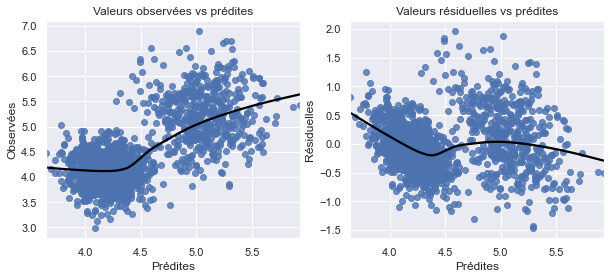

In [82]:
# Linearite:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel="Prédites", ylabel="Observées")

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel="Prédites", ylabel="Résiduelles")
    
linearity_test(res_lin, Reg_Lin_Train_df["margin_low"])

La relation n'est pas linéaire, l'hypothèse de linéarité n'est pas vérifiée. Solutions potentielles :

Transformation non-linéaire sur les variables dépendantes/indépendantes.
Ajout d'une feature, transformation de features préexistantes (mise au carré par exemple).
Ajout de features non considérées précédemment.

<ipython-input-85-3590cb80c152>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]


La p-value du test d'Aderson-Darling vaux 3.9857722331535204e-05


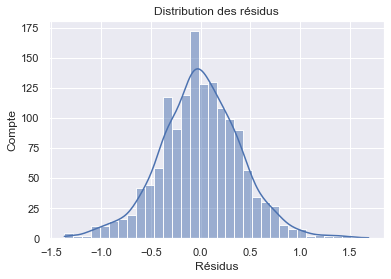

In [85]:
# Creation d'une colonne contenant les residus:
Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]

# Normalite:
print("La p-value du test d'Aderson-Darling vaux", normal_ad(Reg_Lin_Train_df["residual"])[1])

# Graphique:
sns.histplot(Reg_Lin_Train_df["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()


Une p-value inférieure à alpha pour le test d'Anderson-Darling indique que l'hypothèse nulle de normalité de la distribution des résidus est rejetée. Ici, l'hypothèse n'est pas rejetée puisque la p-value obtenue est inférieure au seuil alpha 5 % (ou 1 %), les résidus suivent une distribution Normale.

{'Test Statistic': 109.8601519685849, 'p-value': 2.0828244990467605e-14, 'F-Statistic': 5.853731207796846, 'F-Test p-value': 4.974865092877112e-15}


Text(0.5, 1.0, 'Homoscédasticité')

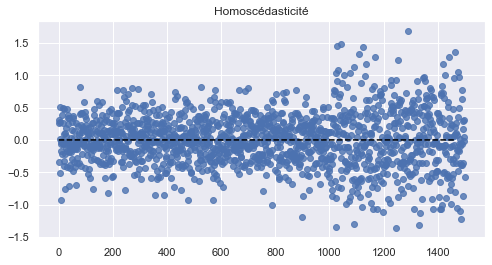

In [88]:
# Homoscedasticite:
white_test = het_white(res_lin.resid, res_lin.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=Reg_Lin_Train_df.index, y=Reg_Lin_Train_df["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(Reg_Lin_Train_df.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

La répartition semble aléatoire sur le graphique. L'hypothèse nulle du test de White est qu'il y a homoscédasticité (les résidus sont dispersés aléatoirement, la variance d'un individu à un autre est constante), l'hypothèse alternative est qu'il y a hétéroscédasticité. On fixe un seuil alpha de 5 % (ou 1 % dans les deux cas ok, mais plus restrictif, voir selon le taux d'erreur acceptable non précisé dans le cahier des charges). La p-value est ici très inférieure au seuil, on ne peut pas rejeter l'hypothèse nulle d'homoscédasticité. L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme vérifiée au risque alpha 5 % (ou 1 %).

/Users/user/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,margin_low,dfb_Intercept,dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_up,dfb_length,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,4.52,0.038028,0.011150,-0.040676,-0.050650,0.028339,-0.018016,0.000894,-0.563593,0.016606,-0.073239,-0.563461,-0.073221
1,3.77,-0.047734,0.031782,0.040802,0.006819,0.006051,0.006096,0.000597,-0.769710,0.006015,-0.059874,-0.769603,-0.059866
2,4.40,-0.028752,0.034142,0.027975,-0.020340,-0.010975,-0.001295,0.000457,0.572488,0.008298,0.052367,0.572356,0.052355
3,3.62,-0.031981,0.060924,0.001406,-0.016400,0.006425,-0.029579,0.000936,-1.118681,0.004467,-0.074934,-1.118778,-0.074940
4,4.04,-0.025618,0.021411,-0.027128,0.056039,-0.049448,-0.009670,0.001171,-1.121058,0.005558,-0.083813,-1.121157,-0.083821


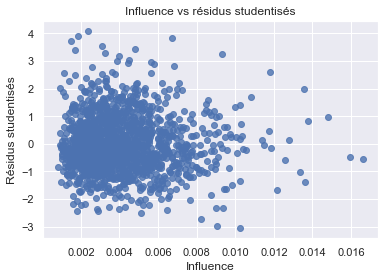

In [89]:
# Identification des individus atypiques et influents (iai), preambulle:
student_resid = res_lin.get_influence().resid_studentized_external
(cooks, p_val_cooks) = res_lin.get_influence().cooks_distance
(dffits, p_val_dffits) = res_lin.get_influence().dffits
leverage = res_lin.get_influence().hat_matrix_diag

# Graphique:
sns.regplot(leverage, res_lin.resid_pearson, fit_reg=False)
plt.title("Influence vs résidus studentisés")
plt.xlabel("Influence")
plt.ylabel("Résidus studentisés")

# Creation d'un dataframe de travail:
iai_df = pd.concat([Reg_Lin_Train_df["margin_low"], res_lin.get_influence().summary_frame()], axis = 1)
iai_df = iai_df.rename(columns={"hat_diag": "leverage"})                                               #hat_diag = leverage donc on change le nom
iai_df.head()

In [87]:
residu=res_lin.resid
residu

0      -0.268676
1      -0.368908
2       0.274067
3      -0.536580
4      -0.537425
          ...   
1495   -0.771741
1496   -0.186887
1497    0.609723
1498    0.361426
1499   -0.209032
Length: 1463, dtype: float64

In [16]:
shapiro_test = stats.shapiro(residu)
shapiro_test

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

Test de validation du modele basé sur les résidus:
On peut voir que la PV est inférieure à alpha, donc les résidus ne suivent donc pas une loi normale.
Le modèle linéaire n'est donc pas valide.

# Estimation des valeurs manquantes

In [93]:
reg_lign=smf.ols('margin_low ~ length+height_left+diagonal+height_right+margin_up',
                data=money_not_null).fit()
print(reg_lign.summary())
plt.savefig('reg_lin.png')

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          2.60e-202
Time:                        13:12:33   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

<Figure size 432x288 with 0 Axes>

In [95]:
margin_low_predict = reg_lign.predict(margin_low_null)
margin_low_null['margin_low']= margin_low_predict
margin_low_null

<ipython-input-95-52df0680a5c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  margin_low_null['margin_low']= margin_low_predict


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36
251,True,171.80,103.26,102.82,3.803308,2.95,113.22
284,True,171.92,103.83,103.76,4.179736,3.23,113.29
334,True,171.85,103.70,103.96,4.127442,3.00,113.36
410,True,172.56,103.72,103.51,4.135034,3.12,112.95
413,True,172.30,103.66,103.50,4.160539,3.16,112.95


In [96]:
tab1=pd.concat([margin_low_null, money_not_null], axis=0)
tab1

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.420000,3.09,111.28
1496,False,172.19,104.63,104.44,5.270000,3.37,110.97
1497,False,171.80,104.01,104.12,5.510000,3.36,111.95
1498,False,172.06,104.28,104.06,5.170000,3.46,112.25


In [97]:
tab1.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

# 3 -  ACP

Préparation

In [98]:
X = tab1.values
names = tab1.index
features = tab1.columns

In [99]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
#X_scaled = scaler.fit_transform(X)

In [100]:
n_components = 7

In [101]:
pca = decomposition.PCA()
pca.fit(X_scaled)

PCA()

In [102]:
pca.explained_variance_ratio_

array([0.49249385, 0.1457059 , 0.11277013, 0.10227432, 0.08450015,
       0.04620555, 0.01605009])

In [103]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([49.25, 14.57, 11.28, 10.23,  8.45,  4.62,  1.61])

In [104]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 49.,  64.,  75.,  85.,  94.,  98., 100.])

In [105]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7]

In [106]:
pcs = pca.components_
pcs

array([[-0.50828546, -0.07613949,  0.26604143,  0.32372561,  0.44693704,
         0.37421587, -0.46955525],
       [ 0.04480819,  0.92923721,  0.33440691,  0.13342362, -0.05842889,
         0.01212936,  0.03632524],
       [ 0.09636598, -0.32758374,  0.89195327, -0.04564791, -0.096176  ,
        -0.23731127,  0.14202695],
       [ 0.08597533, -0.09821372, -0.11894256,  0.91120183, -0.07251739,
        -0.33322832,  0.14908495],
       [-0.14405432,  0.11321689, -0.07803282, -0.20137565,  0.46942219,
        -0.80183365, -0.23768597],
       [ 0.12870829,  0.00662163,  0.0054876 ,  0.00190232,  0.69966278,
         0.1854864 ,  0.67780778],
       [-0.82803532,  0.03003377, -0.03932891, -0.06686997, -0.26914599,
        -0.12294391,  0.46891615]])

In [107]:
pcs.T

array([[-0.50828546,  0.04480819,  0.09636598,  0.08597533, -0.14405432,
         0.12870829, -0.82803532],
       [-0.07613949,  0.92923721, -0.32758374, -0.09821372,  0.11321689,
         0.00662163,  0.03003377],
       [ 0.26604143,  0.33440691,  0.89195327, -0.11894256, -0.07803282,
         0.0054876 , -0.03932891],
       [ 0.32372561,  0.13342362, -0.04564791,  0.91120183, -0.20137565,
         0.00190232, -0.06686997],
       [ 0.44693704, -0.05842889, -0.096176  , -0.07251739,  0.46942219,
         0.69966278, -0.26914599],
       [ 0.37421587,  0.01212936, -0.23731127, -0.33322832, -0.80183365,
         0.1854864 , -0.12294391],
       [-0.46955525,  0.03632524,  0.14202695,  0.14908495, -0.23768597,
         0.67780778,  0.46891615]])

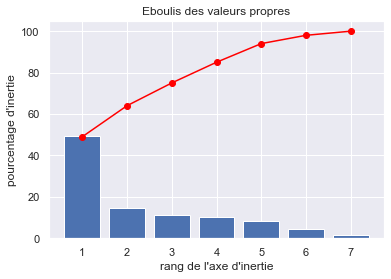

<Figure size 432x288 with 0 Axes>

In [108]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)
plt.savefig('eboulis.png')

In [109]:
x, y = 0,1

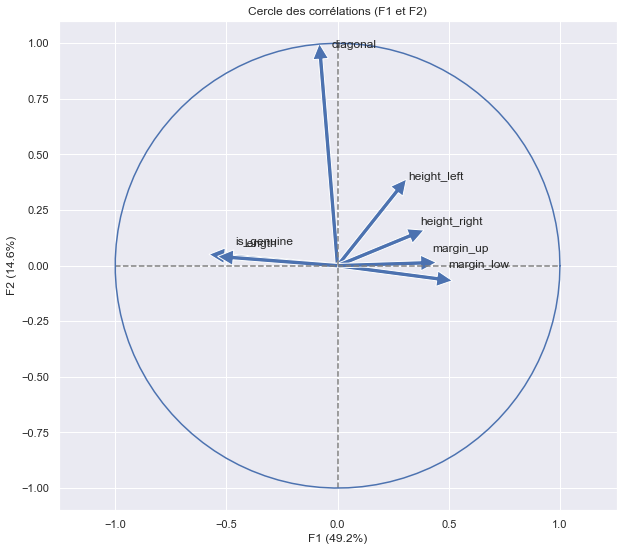

<Figure size 432x288 with 0 Axes>

In [110]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)
plt.savefig('cercle_correlation.png')

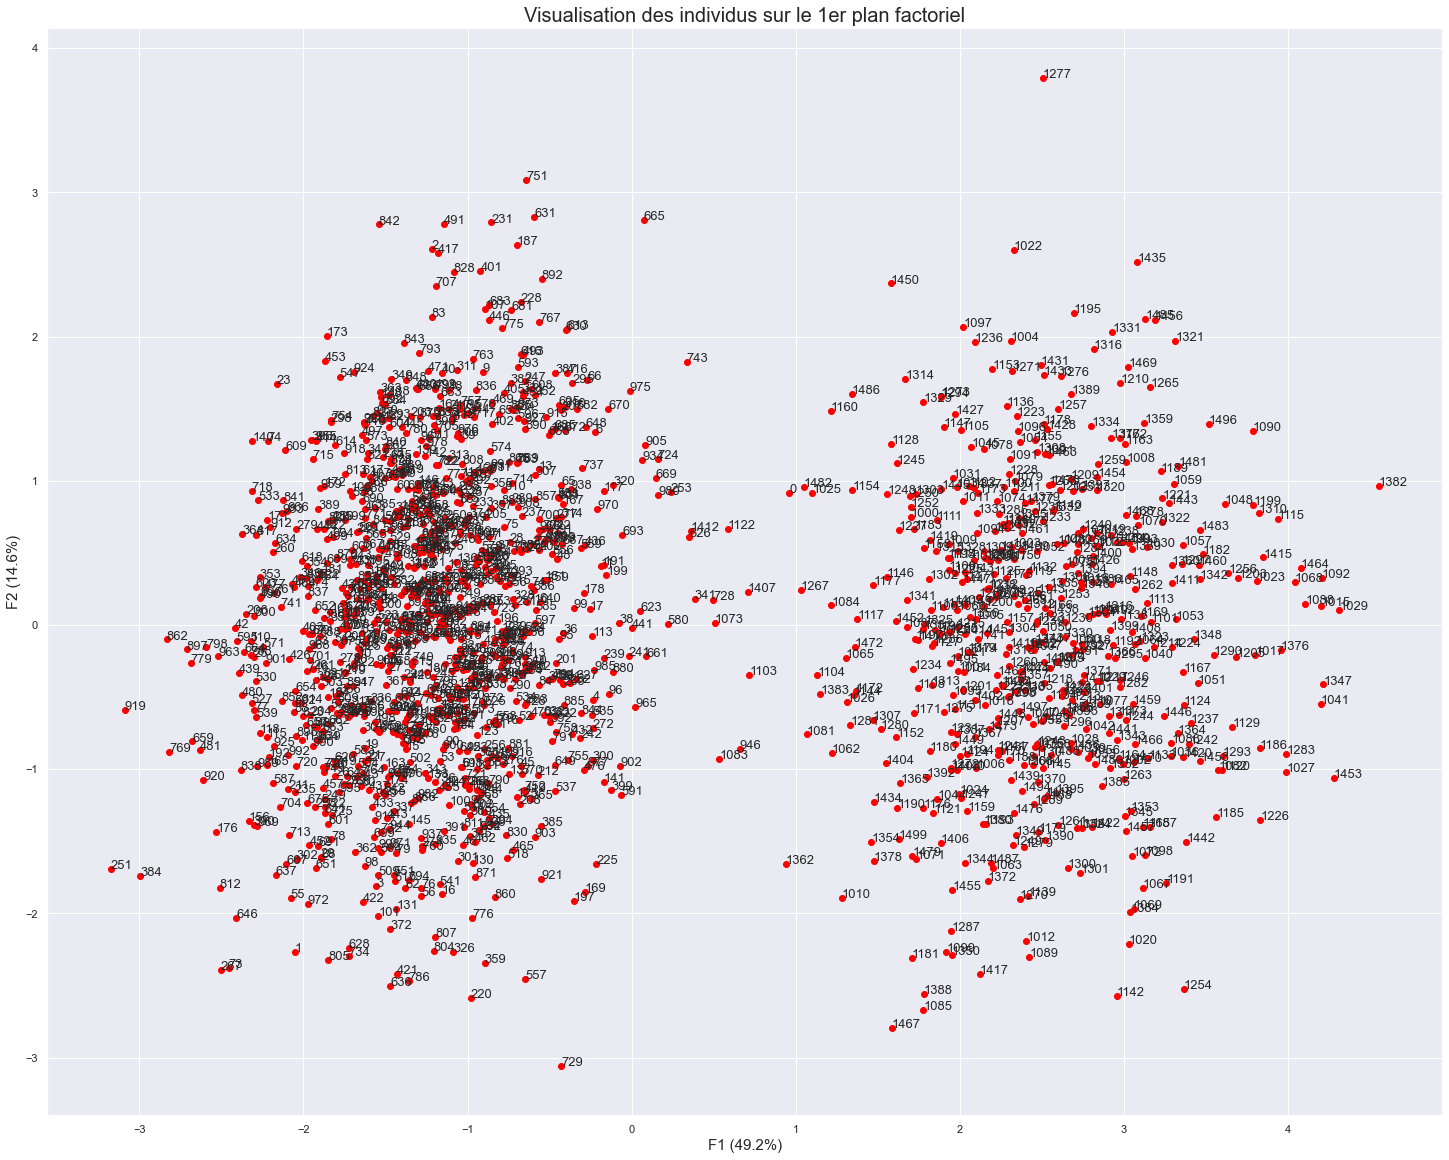

In [111]:
# Visualisation

X_proj = pca.transform(X_scaled)
plt.figure(figsize=(25, 20))

plt.scatter(X_proj[:, 0], X_proj[:, 1], c="red")
for i,(x,y) in enumerate(X_proj[:,[0,1]]):
                    plt.text(x, y, tab1.index[i], fontsize='13') 

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize=15)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize=15)
plt.title("Visualisation des individus sur le 1er plan factoriel".format(X_proj.shape[0]), fontsize=20)

plt.savefig("Visualisation_ACP_groupe.png")
plt.show()

# K-MEAN

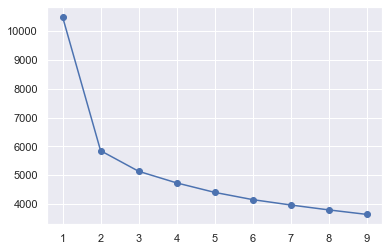

<Figure size 432x288 with 0 Axes>

In [112]:
# Methode des coudes 

import sklearn
from sklearn.cluster import KMeans
from sklearn import metrics

inerties=[]


for k in range(1, 10): # On va calculer l'inertie pour nbre_groupe = 1,2,...10
    km = sklearn.cluster.KMeans(n_clusters=k)
    km.fit(X_scaled)
    inerties.append(km.inertia_)

plt.plot(range(1, 10), inerties, marker='o')
plt.show()
plt.savefig('Methode des coudes.png')

In [113]:
#methode kmean - création de groupes
from sklearn.cluster import KMeans
part=sklearn.cluster.KMeans(n_clusters=2)
part.fit(X_scaled)
clust=part.labels_
clust

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [114]:
#afficher les  groupes 
tab2 = tab1.drop(columns=['is_genuine']).copy()
tab2["clust"] = clust
tab3 = tab2.sort_values("clust")
tab3
# clust 0
#tab3.reset_index(inplace=True)
#clust_0 = tab3[tab3['clust']==0]['is_genuine']
#clust_0

,diagonal,height_left,height_right,margin_low,margin_up,length,clust
72,171.94,103.89,103.45,4.318525,3.25,112.79,0
643,172.07,103.83,103.71,4.440000,2.99,113.11,0
644,171.81,103.91,103.78,3.660000,3.28,113.59,0
645,171.73,103.82,103.85,3.970000,3.12,112.85,0
646,171.59,103.23,103.64,4.010000,2.94,113.59,0
...,...,...,...,...,...,...,...
1152,171.83,103.83,103.92,5.340000,3.22,112.03,1
1151,171.97,104.19,104.05,4.790000,3.18,111.46,1
1150,171.79,104.86,104.34,5.390000,3.14,113.02,1
1163,172.34,104.36,103.83,6.030000,3.44,111.44,1


In [115]:
centroid=tab3.groupby('clust').mean()
centroid.to_csv('centroid.csv')
centroid

,diagonal,height_left,height_right,margin_low,margin_up,length
clust,,,,,,
0,171.987622,103.948412,103.807742,4.117826,3.052837,113.202727
1,171.899900,104.192265,104.146112,5.216973,3.349339,111.626894


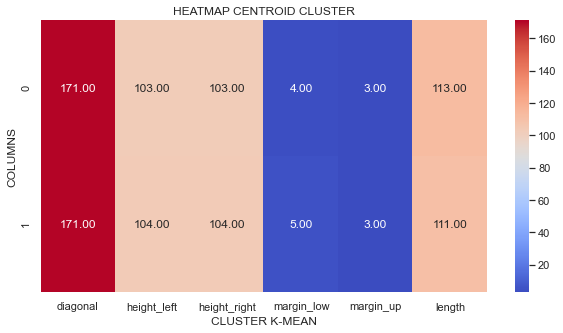

In [116]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(
    centroid.astype(int), ax=ax, annot=True, cbar=True, cmap="coolwarm", fmt="0.2f"
)
_ = ax.set(
    title=f"HEATMAP CENTROID CLUSTER",
    xlabel="CLUSTER K-MEAN",
    ylabel="COLUMNS",
)
plt.savefig('heatmap_centroid_cluster.png')

In [39]:
# Tableau de contingeance/confusion
tableau_contingeance = pd.crosstab(clust, tab1['is_genuine'], rownames=['cluster'])
tableau_contingeance

is_genuine,False,True
cluster,,
0,2,999
1,498,1


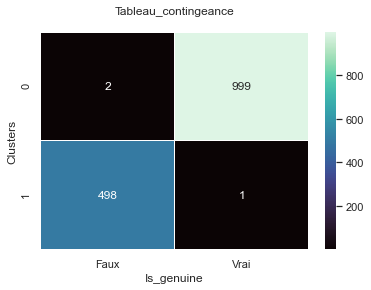

In [40]:
# Graphique:
sns.heatmap(tableau_contingeance,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Is_genuine")
plt.ylabel("Clusters")
plt.title("Tableau_contingeance\n")
plt.savefig('tableau_contingeance.png')

On remarque que Le cluster 0 est le groupe des faux billets et le cluster 1 est le groupe de vrai billets

# Régression logistique

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # decoupage des données
from sklearn.metrics import mean_squared_error , classification_report, accuracy_score

In [42]:
# Découpage du jeu de données 
xlog=tab1.drop("is_genuine", axis=1) # entrainer le modele
ylog=tab1["is_genuine"] # test du modele 
x_train, x_test, y_train, y_test = train_test_split(xlog, ylog, test_size= 0.2) # on pren 20% pour tester le modele


Construction du modèle 

In [43]:
modele_log= LogisticRegression() 
modele_log= modele_log.fit(x_train, y_train)

In [44]:
# Performance du modèle
modele_log_predict= modele_log.predict(x_test)
accuracy_score(modele_log_predict, y_test) # compare ce qu'il  prédit avec les vraies valeurs observées de ytest

0.9866666666666667

In [45]:
modele_log_predict

array([False,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True, False,  True, False,
       False,  True, False, False,  True, False, False, False, False,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False,  True,  True,  True,  True,  True, False, False,
        True, False, False,  True, False, False,  True,  True,  True,
       False, False,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True, False,  True,
        True,  True, False,  True, False,  True, False, False,  True,
        True,  True,

In [46]:
modele_log.predict_proba(x_test)

array([[9.99975217e-01, 2.47830416e-05],
       [3.37001318e-03, 9.96629987e-01],
       [4.12910088e-04, 9.99587090e-01],
       [6.14071818e-04, 9.99385928e-01],
       [4.61853888e-04, 9.99538146e-01],
       [9.73871394e-01, 2.61286060e-02],
       [4.52447691e-05, 9.99954755e-01],
       [8.38743801e-01, 1.61256199e-01],
       [5.26985877e-04, 9.99473014e-01],
       [7.03203961e-02, 9.29679604e-01],
       [2.96704195e-03, 9.97032958e-01],
       [2.04393889e-02, 9.79560611e-01],
       [3.37419531e-03, 9.96625805e-01],
       [5.87476448e-03, 9.94125236e-01],
       [9.98357894e-01, 1.64210577e-03],
       [1.76821494e-03, 9.98231785e-01],
       [3.42026859e-02, 9.65797314e-01],
       [2.21144232e-04, 9.99778856e-01],
       [1.84506333e-02, 9.81549367e-01],
       [6.32409960e-03, 9.93675900e-01],
       [9.95810715e-01, 4.18928460e-03],
       [9.95802495e-01, 4.19750511e-03],
       [1.89228517e-03, 9.98107715e-01],
       [4.95523275e-04, 9.99504477e-01],
       [6.698047

In [47]:
tab1

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.420000,3.09,111.28
1496,False,172.19,104.63,104.44,5.270000,3.37,110.97
1497,False,171.80,104.01,104.12,5.510000,3.36,111.95
1498,False,172.06,104.28,104.06,5.170000,3.46,112.25


In [48]:
# Evaluation de la performance du modèle
cr=classification_report(modele_log_predict, y_test)
print(cr)

              precision    recall  f1-score   support

       False       0.97      0.99      0.98       103
        True       0.99      0.98      0.99       197

    accuracy                           0.99       300
   macro avg       0.98      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



Precision — What percent of your predictions were correct?
Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.
Precision:- Accuracy of positive predictions.
Precision = TP/(TP + FP)


Recall — What percent of the positive cases did you catch?
Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall:- Fraction of positives that were correctly identified.


Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy. F1 Score = 2*(Recall * Precision) / (Recall + Precision)

In [49]:
# 
tab_contain_log = pd.crosstab(modele_log_predict, y_test, rownames=['Predictions'], margins=True , margins_name='Total')
tab_contain_log

is_genuine,False,True,Total
Predictions,,,
False,102,1,103
True,3,194,197
Total,105,195,300


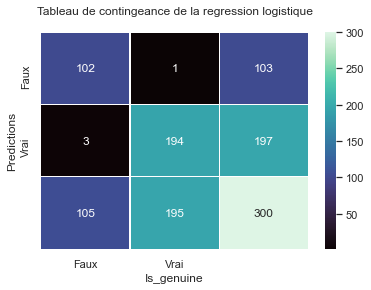

In [50]:
# Graphique:
sns.heatmap(tab_contain_log,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Is_genuine")
plt.ylabel("Predictions")
plt.title("Tableau de contingeance de la regression logistique\n")
plt.savefig('Tableau de contingeance de la regression logistique.png')

In [51]:
def prediction(fichier_test):
    # defini le df
    data = pd.read_csv(fichier_test)
    
    # def X_test
    X_test = data.iloc[:, :-1]
    
    # resultat du model
    reg_log_pred = modele_log.predict(X_test)
    reg_log_prob_true = modele_log.predict_proba(X_test)[:,1]
    reg_log_prob_false = modele_log.predict_proba(X_test)[:,0]
    
    # Creation des colonnes 
    data["is_genuine_pred"] = reg_log_pred
    data['proba true'] = reg_log_prob_true
    data['proba false'] = reg_log_prob_false
    
    # Résultat
    return(data[['diagonal','height_left','height_right','margin_low','margin_up','length','id',  'is_genuine_pred','proba true','proba false']].set_index('id'))

In [52]:
prediction('billets_production.csv')

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_pred,proba true,proba false
id,,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,False,0.006219,0.993781
A_2,171.87,104.17,104.13,6.00,3.31,112.09,False,0.000955,0.999045
A_3,172.00,104.58,104.29,4.99,3.39,111.57,False,0.001522,0.998478
A_4,172.49,104.55,104.34,4.44,3.03,113.20,True,0.920622,0.079378
A_5,171.65,103.63,103.56,3.77,3.16,113.33,True,0.999673,0.000327
